## Part 2. Why greedy, when you can be exact?

Recall our definition of the oxidation problem from part 1.
This is actually a linear optimization (or linear programming, LP) problem.
The objective function is the sum $\Sigma_i x_i H^f_i$ where all $x_i$ are non-negative.
The feasible region of $X^s$ is constrained by elemental conservation.

In [1]:
# required import
import numpy as np
import time
import inspect
from rich.console import Console
from rich.syntax import Syntax
from tqdm import tqdm
from pqdm.processes import pqdm
import matplotlib.pyplot as plt
from pymatgen.core import Composition
from pymatgen.entries.computed_entries import ComputedEntry
from pymatgen.analysis.phase_diagram import PhaseDiagram
import seaborn as sns
from whygreedy import *
sns.set_theme(style="whitegrid", palette="pastel")
plt.rcParams.update({'font.size': 14})


### Exact solutions with LP: random oxidation reactions
There are many well-established packages for LP problems, here we use [gurobi](https://www.gurobi.com/).
`pip install gurobipy` would install `gurobi` with a limited license enough to solve our problem.
The LP solver for oxidation is implemented in `whygreedy.find_lp`

In [2]:
# printout source with python syntax
console = Console(width=120)
syntax = Syntax(inspect.getsource(find_lp), "python")
console.print(syntax)

def find_lp(oxides: list[Compound], original: Compound) -> Tuple[list[float], float]:                                   
    if len(oxides) == 0:                                                                                                
        return [], - original.formation_energy_per_atom                                                                 
                                                                                                                        
    elements_in_oxides = []                                                                                             
    for oxi in oxides:                                                                                                  
        elements_in_oxides += oxi.elements                                                                              
    elements_in_oxides = set(elements_in_oxides)                                                                        
    elements_in_constraints = sorted(set(original.elements).intersection(elements_in_oxides))                           
                                                                                                                        
    # init gurobi model, suppress output                                                                                
    with gp.Env(empty=True) as env:                                                                                     
        env.setParam('OutputFlag', 0)                                                                                   
        env.setParam('LogToConsole', 0)                                                                                 
        env.start()                                                                                                     
        with gp.Model(env=env) as m:                                                                                    
                                                                                                                        
            # add variables                                                                                             
            x = []                                                                                                      
            for ioxi, oxi in enumerate(oxides):                                                                         
                x_i = m.addVar(name=str(ioxi))                                                                          
                x.append(x_i)                                                                                           
                                                                                                                        
            # add stoi constraints                                                                                      
            c = []                                                                                                      
            for e in elements_in_constraints:                                                                           
                element_sum = 0                                                                                         
                for i, x_i in enumerate(x):                                                                             
                    try:                                                                                                
                        composition = oxides[i].normalized_formula[e]                                                   
                    except KeyError:                                                                                    
                        continue                                                                                        
                    element_sum += composition * x_i                                                                    
       

We will use three different methods to solve random oxidation reactions, again:
- `old` is the original implementation, i.e. the *lazy* greedy algorithm
- `diligent` is the *diligent* greedy algorithm
- `exact` is the exact solution from L

In [3]:
# function to calculate data using old (==lazy), diligent and exact
syntax = Syntax(inspect.getsource(calculate_greedy_vs_exact_oxides), "python")
console.print(syntax)

def calculate_greedy_vs_exact_oxides(pair: list[Compound, list[Compound]], return_mpid=False):                          
    original, oxides = pair                                                                                             
                                                                                                                        
    # greedy solutions                                                                                                  
    dh_old_min = np.inf                                                                                                 
    dh_diligent_min = np.inf                                                                                            
    sol_old_min = None                                                                                                  
    sol_diligent_min = None                                                                                             
    for i in range(len(oxides)):                                                                                        
        sol_old, dh_old = find_greedy_old(oxides, original, first_choice=i)                                             
        sol_diligent, dh_diligent = find_greedy(oxides, original, first_choice=i, diligent_greedy=True)                 
        if dh_old < dh_old_min:                                                                                         
            dh_old_min = dh_old                                                                                         
            sol_old_min = sol_old                                                                                       
        if dh_diligent < dh_diligent_min:                                                                               
            dh_diligent_min = dh_diligent                                                                               
            sol_diligent_min = sol_diligent                                                                             
                                                                                                                        
    sol_exact, dh_exact = find_lp(oxides, original)                                                                     
                                                                                                                        
    assert check_solution(sol_old_min, oxides, original)                                                                
    assert check_solution(sol_diligent_min, oxides, original)                                                           
    assert check_solution(sol_exact, oxides, original)                                                                  
                                                                                                                        
    # greedy solution should be no better than the exact                                                                
    assert dh_exact <= min([dh_diligent_min, dh_old_min]) + 1e-7  # floating point error                                
                                                                                                                        
    # to reduce size                                                                                                    
    if return_mpid:                                                                                                     
        original = original.mpid                                                                                        
        oxides = [oxide.mpid for oxide in oxides]                                                                       
                                                                                                                        
    record = {                                                                                                          
       

In [4]:
seed_max = 1000
random_pairs = [
    gen_random_data(["A", "B", "C", "D"], num_oxi_per_chemical_system=5, seed=seed)
    for seed in range(seed_max)
]
records_random = pqdm(random_pairs, calculate_greedy_vs_exact_oxides, n_jobs=8)  # ~ 16 s


QUEUEING TASKS | :   0%|          | 0/1000 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1000 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
def plot_dh_diff(records, percent=False, yunit="eV/atom"):

    nonzero_dh_diff_lazy = []
    nonzero_dh_diff_diligent = []
    lazy_wrong = []
    diligent_wrong = []
    for i, record in enumerate(records):
        dh_lazy = record["dh_old"]
        dh_diligent = record["dh_diligent"]
        dh_exact = record["dh_exact"]
        diff_lazy = dh_exact - dh_lazy
        diff_diligent = dh_exact - dh_diligent
        # exact should never be worse
        assert diff_diligent < 1e-7
        assert diff_lazy < 1e-7

        if abs(diff_diligent) > 1e-7:
            diligent_wrong.append(i)
            if percent:
                diff_diligent = abs(100 * diff_diligent/dh_exact)
            nonzero_dh_diff_diligent.append(diff_diligent)

        if abs(diff_lazy) > 1e-7:
            lazy_wrong.append(i)
            if percent:
                diff_lazy = abs(100 * diff_lazy/dh_exact)
            nonzero_dh_diff_lazy.append(diff_lazy)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    ymin = min(min(nonzero_dh_diff_diligent), min(nonzero_dh_diff_lazy))
    ymax = max(max(nonzero_dh_diff_diligent), max(nonzero_dh_diff_lazy))
    ylim = [ymin - abs(0.05*ymin), ymax + abs(0.05*ymax)]
    for name, data, ax in zip(
        ["Lazy", "Diligent",],
        [nonzero_dh_diff_lazy, nonzero_dh_diff_diligent],
        [ax1, ax2]
    ):

        ax.bar(range(len(data)), sorted(data))
        if percent:
            ax.set_ylabel(r"$\Delta$H difference w.r.t. the exact solution (%)")
        else:
            ax.set_ylabel(r"$\Delta H_{Exact} - \Delta H_{Greedy}$" + " {}".format(yunit))
        ax.set_title("{} greedy vs LP".format(name))
        ax.set_xlabel("{} out of {} reactions".format(len(data), len(records)))
        ax.set_ylim(ylim)
        if percent:
            print("{}: max diff = {:.4f} {}".format(name, max(data), yunit))
        else:
            print("{}: max diff = {:.4f} {}".format(name, min(data), yunit))
    fig.tight_layout()
    return fig, lazy_wrong, diligent_wrong

Lazy: max diff = 21.8311 (%)
Diligent: max diff = 12.3397 (%)
False
92


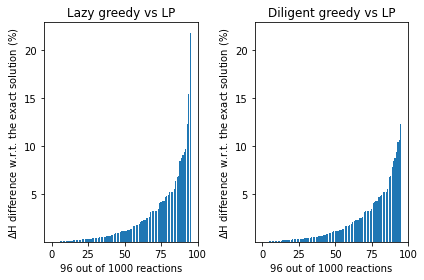

In [7]:
fig, lazy_wrong, diligent_wrong = plot_dh_diff(records_random, yunit="(%)", percent=True)
fig.savefig("data/float/dh_diff_random.eps")
print(set(lazy_wrong) == set(diligent_wrong))
both_wrong = set(lazy_wrong).intersection(set(diligent_wrong))
print(len(both_wrong))

Out of 1000 randomly generated oxidation reactions, in 96 of them LP finds a better solution than the lazy or diligent greedy method, and LP never finds a worse solution. The percent difference in $\Delta H$ can be as large as 21.83% for *lazy* and 12.34% for *diligent*. In 92 of the 96 cases, both lazy and diligent methods failed to find the exact solution.

### Timing
Since the old implementation requires loop over all possible `first_choice`, it is significantly slower than the linear programming method when the # of oxides is large.

In [8]:
original, oxides = gen_random_data(["A", "B", "C", "D"], 5, 42)
print("# of oxides:", len(oxides))
%timeit find_lp(oxides, original)
%timeit for i in range(len(oxides)) : find_greedy_old(oxides, original, first_choice=i)

# of oxides: 75
1.6 ms ± 6.29 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
15.3 ms ± 52.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


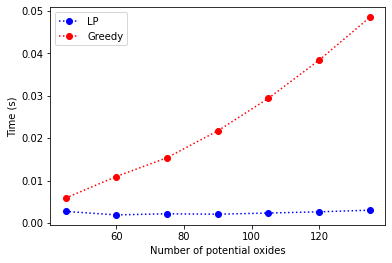

In [9]:
def timing(find_function, oxides, original):
    ts1 = time.perf_counter()
    if "greedy" in find_function.__name__:
        for i in range(len(oxides)):
            find_function(oxides, original, first_choice=i)
    else:
        find_function(oxides, original)
    ts2 = time.perf_counter()
    return ts2 - ts1

def timing_plot(num_oxides_per_chemsys = tuple(range(3, 10))):
    time_lp = []
    time_greedy = []
    num_oxides = []
    for n in num_oxides_per_chemsys:
        original, oxides = gen_random_data(["A", "B", "C", "D"], n, 42)
        timing_greedy = timing(find_greedy_old, oxides, original)
        timing_lp = timing(find_lp, oxides, original)
        time_lp.append(timing_lp)
        time_greedy.append(timing_greedy)
        num_oxides.append(len(oxides))

    fig, ax = plt.subplots()
    ax.plot(num_oxides, time_lp, "bo:", label="LP")
    ax.plot(num_oxides, time_greedy, "ro:", label="Greedy")
    ax.set_xlabel("Number of potential oxides")
    ax.set_ylabel("Time (s)")
    ax.legend()
    return fig

fig_timing = timing_plot()
fig_timing.savefig("data/float/timing.eps")

We should note the run time comparison here is done for wall clock time, the actual CPU time could be different.

### MP dataset: competing phases
We now move on to the competing phase problem (Fig. 5 of the original paper).

In [3]:
# first load competing pairs, [Compound, list[Compound]]
# in this case json dump is much slower than pkl dump

competing_pairs_pkl = "data/part2/mp_competing_pairs.pkl"
if file_exists(competing_pairs_pkl):
    competing_pairs = pkl_load(competing_pairs_pkl)
else:
    competing_pairs = load_mp_competing_pairs()  # ~ 150 s
    pkl_dump(competing_pairs, competing_pairs_pkl)

loaded in: 1.8046 s


In [4]:
# load data if already calculated, otherwise calculate in parallel
# some pairs are quite large as LP problems, so you may need an academic lic for gurobi
# https://www.gurobi.com/academia/academic-program-and-licenses/

records_mpcp_pkl = "data/part2/records_mpcp.pkl"

if file_exists(records_mpcp_pkl):
    records_mpcp = pkl_load(records_mpcp_pkl)
else:
    records_mpcp = pqdm(competing_pairs, calculate_greedy_vs_exact_cp, n_jobs=8)  # took ~23 h, mainly by greedy
    pkl_dump(records_mpcp, records_mpcp_pkl)

assert len(records_mpcp) == len(competing_pairs) and all(isinstance(r, dict) for r in records_mpcp)

loaded in: 19.6430 s


In [5]:
# there are two compounds do not have competing phases, so we have no iterations in greedy methods and dh values are calculated as the initial value `inf`. we will set them to zero.
for i, (c, cps) in enumerate(competing_pairs):
    if len(cps) == 0:
        print("="*6)
        print(c, c.mpid, cps)
        print("dh_old calculated as", records_mpcp[i]["dh_old"], "set to 0")
        records_mpcp[i]["dh_old"] = 0.0
        print("dh_diligent calculated as", records_mpcp[i]["dh_diligent"], "set to 0")
        records_mpcp[i]["dh_diligent"] = 0.0

{'Pt': 1.0} mp-126 []
dh_old calculated as inf set to 0
dh_diligent calculated as inf set to 0
{'Ne': 1.0} mp-111 []
dh_old calculated as inf set to 0
dh_diligent calculated as inf set to 0


# of disagreements between lazy and diligent: 25006 / 126320
# of better diligent: 19233


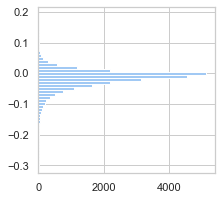

In [6]:
# how is diligent vs greedy?
fig = plot_diligent_vs_lazy(records_mpcp, figsize=(3.3, 2.5),xlabel="", ylabel="", bins=50, orientation="horizontal")
fig.set_figheight(3)
fig.set_figwidth(3.3)
fig.tight_layout()
fig.savefig("data/float/diligent_vs_lazy_mpcp.eps")


In [13]:
# by default `calculate_greedy_vs_exact` returns a dict whose "original" and "oxides" fields are <mpid> to save i/o
# so we need lookup tables for ehull and compound
mpid_to_compound = dict()
for c, _ in competing_pairs:
    mpid_to_compound[c.mpid] = c

mpid_to_ehull = dict()
for d in json_load("data/mp.json.gz"):
    mpid = d["task_id"]
    ehull = d["e_above_hull"]
    mpid_to_ehull[mpid] = ehull

Lazy: max diff = -0.3402 eV/atom
Diligent: max diff = -0.3632 eV/atom


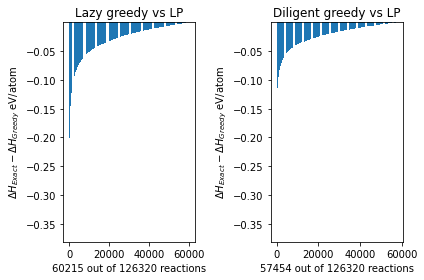

In [14]:
# take a look at the differences between LP and greedy
fig, lazy_wrong, diligent_wrong = plot_dh_diff(records_mpcp, percent=False, yunit="eV/atom")
fig.savefig("data/float/dh_diff_mpcp.eps")

In [15]:
def generate_fig5_data(records, dh_field, supress_small_values=1e-7, limit_ehull=False) -> list[float]:
    """
    [from page 2549 of the original article]
    > changing all positive reaction enthalpies to a value
    > of 0 meV/atom to match the “stable” EATCH values and
    > making positive all remaining negative reaction enthalpies.
    """
    fig5_data = []
    for record in tqdm(records):
        dh = record[dh_field]
        if dh > 0:
            dh = 0
        else:
            dh = - dh
        ehull = mpid_to_ehull[record["original"]]
        if limit_ehull and ehull >= 0.05:
            continue
        fig5_delta = dh - ehull
        if supress_small_values and abs(fig5_delta) < supress_small_values:
            fig5_delta = 0.0
        fig5_data.append(fig5_delta)
    return fig5_data

In [16]:
import pandas as pd
fig5_data_old = generate_fig5_data(records_mpcp, dh_field="dh_old")
fig5_data_diligent = generate_fig5_data(records_mpcp, dh_field="dh_diligent")
fig5_data_exact = generate_fig5_data(records_mpcp, dh_field="dh_exact")

fig5_df = pd.DataFrame(np.array([fig5_data_old, fig5_data_diligent, fig5_data_exact]).T, columns=["Lazy", "Diligent", "LP"])

100%|██████████| 126320/126320 [00:00<00:00, 1490150.45it/s]


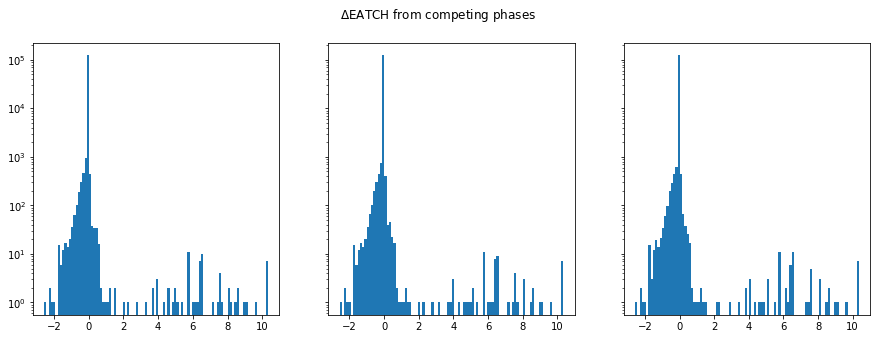

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle(r"$\Delta$EATCH from competing phases")

for i, col in enumerate(fig5_df.columns):
    data = fig5_df[col]
    axes[i].hist(data, bins=100)
    # sns.histplot(ax=axes[i], data=fig5_df, x=col, bins=100)
    # axes[i].set_xlim([-0.05, 0.01])
    axes[i].set_yscale('log')

It is clear that neither of the subfigures is similar to Fig. 5 from the original paper. A few things to consider here:

1. The caption of Fig. 5 says "... the 126 320 materials in the MP database." We extracted the data from the bar chart, and we find the sum of all bars is around 98.2K. Data extraction was performed using [WebPlotDigitizer](https://apps.automeris.io/wpd/) and extracted data can be found in [data/part2/fig5.json](./data/part2/fig5.json) (the image used for extraction is [data/part2/fig5.jpeg](./data/part2/fig5.jpeg)). The mean value of the extracted data ranges is estimated to be 0.025543 ~ 0.024457 eV/atom, which is quite different from 0.0395 eV/atom from the original paper. Thus it is possible that Fig. 5 from the original paper is showing truncated data.

In [18]:
# sum of bars in the original fig. 5
original_fig5_data = json_load("data/part2/fig5.json")["datasetColl"][0]["data"]
original_fig5_data = [r["value"][0] for r in original_fig5_data]
original_fig5_data_total = sum(original_fig5_data) * 1e4
print("sum of bars:", original_fig5_data_total)

# estimate range of MAE
barwidth = 0.05 / (len(original_fig5_data) - 1)  # discard two half-bars outside the range
# from right to left, first bar
right_edge = 0.5 * barwidth
left_edge = 0.5 * -barwidth
data_max = []
data_min = []
for i, v in enumerate(original_fig5_data):
    if i != 0:
        right_edge = left_edge
        left_edge = right_edge - barwidth
    data_max.append(right_edge)
    data_min.append(left_edge)
print("range of the mean value: {:.6f} -- {:.6f}".format(np.mean(data_min), np.mean(data_max)))


sum of bars: 98178.55790822612
range of the mean value: -0.025543 -- -0.024457


2. The lower limit of x-axis in Fig. 5 is -0.05 eV. This itself is not strange, but in the [original code](https://zenodo.org/record/5110202#.YlJgpsjMJyg), a 50 meV EATCH (energy above the convex hull) stability filter is constantly applied ([Analyser.py: line 283](./data/part2/Analyser.py)). It is thus possible this stability filter was mistakenly applied for plotting Fig. 5.

In [19]:
with open("data/part2/Analyser.py", "r") as f:
    analyzer_of_the_orignal_code = f.readlines()
start_line = 277
end_line = start_line + 15
syntax = Syntax("".join(analyzer_of_the_orignal_code[start_line-1:end_line]), "python", line_numbers=True,start_line=start_line)
console.print(syntax)

  277 def Make_Property_Dict(compound):                                                                                 
  278     '''                                                                                                           
  279     Function to be iterated over all compounds.                                                                   
  280     '''                                                                                                           
  281     PDict = {}                                                                                                    
  282                                                                                                                   
  283     if abs(compound['e_above_hull']) < criteria/1000: #if stable                                                  
  284                                                                                                                   
  285         #### FOR NUM PHASES                                                                                       
  286         competing_phases_id_withform = []                                                                         
  287         competing_phase_no = 0                                                                                    
  288         comp_listdict =[]                                                                                         
  289                                                                                                                   
  290                                                                                                                   
  291         #### FOR NUM OXIDES                                                                                       
  292         oxide_no = 0                                                                                              
  293                                                                                                                   

3. One possible reason that there are positive values in *our* plots of **$\Delta$EATCH from competing phases** is the yet-to-be-updated EATCH values in MP: It seems that the EATCH values obtained from MP is not calculated on-the-fly such that if a new, more stable compound is admitted to the database, the old EATCH values of old compounds do not change. Here is an example:

In [20]:
# take a system that has a large positive value of $\Delta$EATCH
for i, delta in enumerate(fig5_data_exact):
    if delta > 1:
        target_competing_pair = competing_pairs[i]
        target_record = records_mpcp[i]["dh_exact"]
        break
target_c, target_cps = target_competing_pair

# use pymatgen `PhaseDiagram` to calculate EATCH, note this can be considered a version of linear programming (barycentric coordinates)
def pymatgen_ehull(c: Compound, cps: list[Compound]):
    c_e = ComputedEntry(Composition(c.normalized_formula), c.formation_energy_per_atom)
    cp_es = []
    for cp in cps:
        cp_es.append(ComputedEntry(Composition(cp.normalized_formula), cp.formation_energy_per_atom))
    pdEntries = [c_e, ] + cp_es
    pd = PhaseDiagram(pdEntries)
    decomp, eAboveHull = pd.get_decomp_and_e_above_hull(c_e)
    return sorted(decomp.values()), eAboveHull

_, pymatgen_hull = pymatgen_ehull(target_c, target_cps)
_, lp_hull = find_lp(target_cps, target_c)
print("decomposition of :{}".format(target_c.mpid))
print("pymatgen bary_coord gives: {:.6f}".format(pymatgen_hull))
print("LP gives: {:.6f}".format(-lp_hull))  # negative decomposition enthalpy
print("However, value from MP for {} is: {:.6f}".format(target_c.mpid, mpid_to_ehull[target_c.mpid]))

# what if we exclude a competing phase from the list?
print("="*6)
exclude_index = 19
print("exclude compound {} with formation energy: {:.6f}".format(target_cps[exclude_index].mpid, target_cps[exclude_index].formation_energy_per_atom))
updated_target_cps = [cp for cp in target_cps]
updated_target_cps.pop(exclude_index)
_, pymatgen_hull = pymatgen_ehull(target_c, updated_target_cps)
_, lp_hull = find_lp(updated_target_cps, target_c)
print("pymatgen bary_coord gives: {:.6f}".format(pymatgen_hull))
print("LP gives: {:.6f}".format(-lp_hull))  # negative decomposition enthalpy

decomposition of :mp-1318211
pymatgen bary_coord gives: 10.402309
LP gives: 10.402309
However, value from MP for mp-1318211 is: 0.044175
exclude compound mp-778012 with formation energy: -13.568631
pymatgen bary_coord gives: 0.044175
LP gives: 0.044175


### MP dataset: oxidation reactions
Finally, we look at the results for oxidation reactions (Fig. 6 of the original paper).

In [21]:
oxidation_pairs_pkl = "data/part2/mp_oxidation_pairs.pkl"
if file_exists(oxidation_pairs_pkl):
    oxidation_pairs = pkl_load(oxidation_pairs_pkl)
else:
    oxidation_pairs = load_mp_oxide_pairs()
    pkl_dump(oxidation_pairs, oxidation_pairs_pkl)


loaded in: 4.4795 s


In [22]:
records_mpox_pkl = "data/part2/records_mpox.pkl"

if file_exists(records_mpox_pkl):
    records_mpox = pkl_load(records_mpox_pkl)
else:
    records_mpox = pqdm(oxidation_pairs, calculate_greedy_vs_exact_oxides, n_jobs=8)  # took ~10 min
    pkl_dump(records_mpox, records_mpox_pkl)

assert len(records_mpox) == len(oxidation_pairs)


loaded in: 26.9873 s


Lazy: max diff = -0.7733 eV/atom
Diligent: max diff = -0.5424 eV/atom


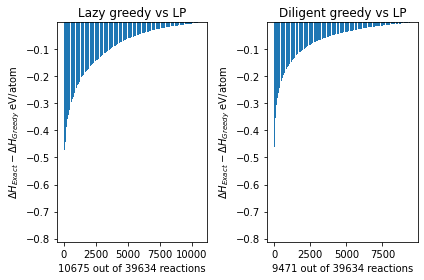

In [23]:
fig, lazy_wrong, diligent_wrong = plot_dh_diff(records_mpox, percent=False, yunit="eV/atom")
fig.savefig("data/float/dh_diff_mpox.eps")

In [24]:
# for lazy greedy solutions, how many of them are qualitatively wrong (i.e. wrong oxidation products)?
def set_small_to_zeros(a: list[float], eps=1e-5):
    a = np.array(a)
    a[np.abs(a) < eps] = 0
    return a

quali_diff_cases = []
for r in records_mpox:
    sol_lazy = r["sol_old"]
    sol_exact = r["sol_exact"]
    sol_lazy = set_small_to_zeros(sol_lazy).astype(bool)
    sol_exact = set_small_to_zeros(sol_exact).astype(bool)
    for i in range(len(sol_lazy)):
        if sol_lazy[i] != sol_exact[i]:
            quali_diff_cases.append(r)
            break
print("# of qualitative differences", len(quali_diff_cases), "/", len(records_mpox))


# of qualitative differences 10675 / 39634


In [25]:
# let's look at those with high Delta H difference
def formula_dict_to_string(d:dict):
    return " ".join(["{}{:.3f}".format(k, v) for k, v in d.items()])

def format_solution(oxides: list[Compound], solution:np.ndarray) -> str:
    s = ""
    final = 0
    for i, oxi in zip(solution, oxides):
        if is_close_to_zero(i):
            continue
        s += "\t{:.4f} -- {} -- {:.2f} -- {}\n".format(i, formula_dict_to_string(oxi.normalized_formula), oxi.formation_energy_per_atom, oxi.mpid)
        final += oxi.formation_energy_per_atom * i
    s += "\tenthalpy: {:.4f}".format(final)
    return s

quali_diff_cases = sorted(quali_diff_cases, key=lambda x:x["dh_exact"] - x["dh_old"])
for r in quali_diff_cases[:5]:
    original = r["original"]
    oxides = r["oxides"]
    sol_old = r["sol_old"]
    sol_exact = r["sol_exact"]
    print("="*6)
    print("original: " + formula_dict_to_string(original.normalized_formula) + "\t" + original.mpid)
    print("EXACT solution:")
    print(format_solution(oxides, sol_exact))
    print("lazy GREEDY solution:")
    print(format_solution(oxides, sol_old))

original: Sr0.250 Ca0.250 S0.500	mp-1218330
EXACT solution:
	1.5000 -- Ca0.167 S0.167 O0.667 -- -2.79 -- mp-4406
	1.5000 -- Sr0.167 S0.167 O0.667 -- -2.80 -- mp-5285
	enthalpy: -8.3924
lazy GREEDY solution:
	1.0000 -- S0.250 O0.750 -- -1.75 -- mp-2414
	0.5000 -- Ca0.500 O0.500 -- -3.32 -- mp-2605
	1.5000 -- Sr0.167 S0.167 O0.667 -- -2.80 -- mp-5285
	enthalpy: -7.6190
original: Sr0.500 Se0.250 S0.250	mp-1218707
EXACT solution:
	1.5000 -- Sr0.167 S0.167 O0.667 -- -2.80 -- mp-5285
	1.5000 -- Sr0.167 Se0.167 O0.667 -- -2.16 -- mp-4092
	enthalpy: -7.4481
lazy GREEDY solution:
	0.8750 -- Se0.286 O0.714 -- -1.03 -- mp-27358
	0.7500 -- Sr0.333 O0.667 -- -2.21 -- mp-2697
	1.5000 -- Sr0.167 S0.167 O0.667 -- -2.80 -- mp-5285
	enthalpy: -6.7645
original: Ba0.211 Tb0.105 Cd0.158 S0.526	mp-17513
EXACT solution:
	1.2632 -- Ba0.167 S0.167 O0.667 -- -2.83 -- mp-3164
	0.9474 -- Cd0.167 S0.167 O0.667 -- -1.95 -- mp-8459
	0.8947 -- Tb0.118 S0.176 O0.706 -- -2.79 -- mp-1208801
	enthalpy: -7.9170
lazy GREED

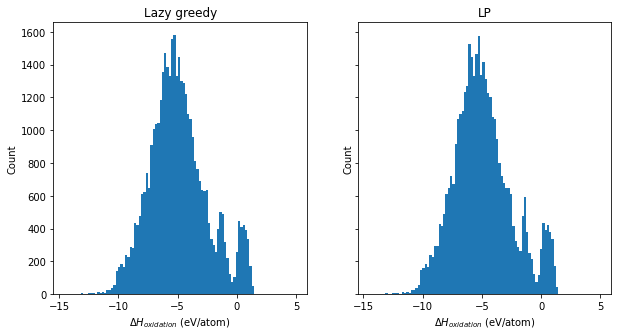

In [26]:
# reproduce Fig. 6 (a)
def plot_dh_distributions(records):
    lazy_oxidation_dhs = []
    exact_oxidation_dhs = []
    for r in records:
        lazy_oxidation_dhs.append(r["dh_old"])
        exact_oxidation_dhs.append(r["dh_exact"])

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

    for ax, data, title in zip(axes, [lazy_oxidation_dhs, exact_oxidation_dhs], ["Lazy greedy", "LP"]):
        ax.hist(data, bins=100)
        ax.set_title(title)
        ax.set_xlabel(r"$\Delta H_{oxidation}$ (eV/atom)")
        ax.set_ylabel("Count")
    return fig

fig = plot_dh_distributions(records=records_mpox)
fig.savefig("data/float/dh_distribution_ox.eps")

# of compounds 33450


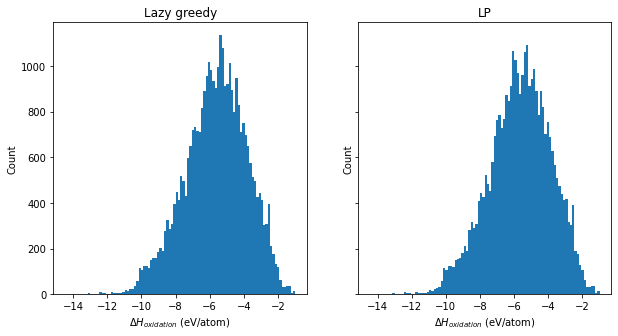

In [27]:
# how about Fig. 6 (c)?
halogens = {"F", "Cl", "Br"}  # no I
records_mpox_no_halogens = [r for r in records_mpox if not set(r["original"].elements).intersection(halogens)]
fig = plot_dh_distributions(records_mpox_no_halogens)

print("# of compounds", len(records_mpox_no_halogens))  # 33470 from the original paper...

Qualitatively, distribution of $\Delta H$ calculated using LP resembles Fig. 6 (a) from the original paper.

In [31]:
# what about Pilling−Bedworth ratio?

# look up table for volume and cell
mpid_to_mvol = dict()
for d in json_load("data/mp.json.gz"):
    mpid = d["task_id"]
    v = d["volume"]
    formula = d["unit_cell_formula"]
    nsites = d["nsites"]
    mpid_to_mvol[mpid] = v / nsites

# function to determine if it 1. decomposes and 2. PBR in [1, 2]
# we added a `top2` argument to reproduce what seems to be the implementation by the original paper (see below)
def is_passivation(original: Compound, oxides: list[Compound], sol:list[float], dh: float, top2=False):
    assert len(oxides) > 0
    if dh >= 0:
        return False
    v_original = mpid_to_mvol[original.mpid]
    # for i, x in enumerate(sol):
    #     v_oxi = mpid_to_mvol[oxides[i].mpid]
    #     pbr = v_oxi / v_original
    #     if x > 1e-5:
    #         v_oxides += v_oxi * x
    # return 1 <= pbr <= 2

    oxi_list = []
    for i, x in enumerate(sol):
        v_oxi = mpid_to_mvol[oxides[i].mpid]
        if x > 1e-5:
            pbr = v_oxi / v_original
            oxi_list.append((i, x, pbr))
    oxi_list = sorted(oxi_list, key=lambda x:x[1], reverse=True)
    if top2:
        oxi_list = oxi_list[:2]
    return all( 1 <= ratio <= 2 for _, _, ratio in oxi_list)

passivation_by_lazy = []
passivation_by_exact = []
for r in records_mpox_no_halogens:
    original, oxides, dh_old, dh_exact, sol_old, sol_exact = [r[k] for k in ["original", "oxides", "dh_old", "dh_exact", "sol_old", "sol_exact"]]
    if is_passivation(original, oxides, sol_old, dh_old, top2=True):
        passivation_by_lazy.append(r)
    if is_passivation(original, oxides, sol_exact, dh_exact, top2=True):
        passivation_by_exact.append(r)
#
# It was found that of the ∼33 000
# materials tested with results shown in Figure 6c, 1438
# degraded to form a set of oxides that all fall into the PBR
# range, indicating self-passivation

print("Lazy satisfy 1 <= PBR <= 2: {}".format(len(passivation_by_lazy)))
print("LP satisfy 1 <= PBR <= 2: {}".format(len(passivation_by_exact)))

Lazy satisfy 1 <= PBR <= 2: 1395
LP satisfy 1 <= PBR <= 2: 1365
